# Stanford Stats 191

## Introduction

This is a re-creation of the Stanford Stats 191 course (see https://web.stanford.edu/class/stats191/), using Python eco-system tools, instead of R. This is lecture "Bootstrapping regression:"


It turns out that it appears that ```statsmodels``` appears to have no support for Bootstrap-style operations.  There are a number of Python packages that claim to support Bootstrap operations, but I decided to use ```numpy``` and its ```sample``` method, and explicitly perform the resampling and parameter re-estimation.

## Initial Notebook Setup

```watermark ``` documents the current Python and package environment, ```black``` is my preferred Python formatter

In [60]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [61]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [62]:
%matplotlib inline

### Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.formula.api import rlm
import statsmodels.api as sm

------
## OLS of Gaussian Noise as Error Term

First, we perform an OLS best fit of a linear model to a dataset with Gaussian Noise

In [64]:
# size of dataset
n_data = 50

# linear parameters
beta_0 = 1.5
beta_1 = 2.0
sigma = 2

x = np.random.normal(0, 1, n_data)
x = np.array(sorted(x))

# linear model with Gaussian noise
y = beta_0 + x * beta_1
#
y = y + np.random.normal(0, 1, n_data) * sigma

Quick plot of dataset

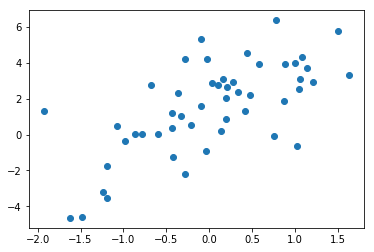

In [65]:
_ = plt.plot(x, y, 'o')

Perform OLS fit to linear model

In [66]:
df_dict = {'x': x, 'y': y}
data = pd.DataFrame(df_dict)

res = ols('y ~ x', data=data).fit()

res.params

Intercept    1.473338
x            2.009848
dtype: float64

In [67]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     39.92
Date:                Sun, 19 Apr 2020   Prob (F-statistic):           8.18e-08
Time:                        19:37:26   Log-Likelihood:                -101.86
No. Observations:                  50   AIC:                             207.7
Df Residuals:                      48   BIC:                             211.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4733      0.268      5.499      0.000       0.935       2.012
x              2.0098      0.318      6.318      0.000       1.370       2.649
==============================================================================
Omnibus:                        0.019   Durbin-Watson:                   2.373
Prob(Omnibus):                  0.990   Jarque-Bera (JB):                0.174
Skew:                           0.030   Prob(JB):                        0.917
Kurtosis:                       2.718   Cond. No.                         1.19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

------------
## Non-Gaussian Errors

Now, consider case where the error term is uniformly distributed (i.e. non-Gaussian).  We have the same model parameters

In [115]:
n_data = 50

beta_0 = 1.5
beta_1 = 2
sigma = 2

x = np.random.normal(0, 1, n_data)
x = np.array(sorted(x))
y = beta_0 + x * beta_1
#
y = (
    y
    + np.random.uniform(low=-1.0, high=1.0, size=n_data)
    * sigma
)

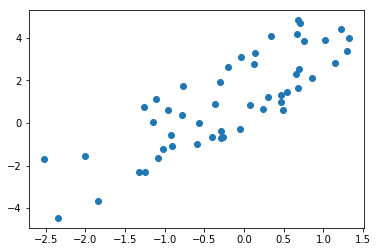

In [116]:
_ = plt.plot(x, y, 'o')

In [117]:
df_dict = {'x': x, 'y': y}
data = pd.DataFrame(df_dict)

res = ols('y ~ x', data=data).fit()

res.params

Intercept    1.388669
x            1.918366
dtype: float64

In [118]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     102.8
Date:                Sun, 19 Apr 2020   Prob (F-statistic):           1.62e-13
Time:                        20:07:11   Log-Likelihood:                -81.728
No. Observations:                  50   AIC:                             167.5
Df Residuals:                      48   BIC:                             171.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3887      0.183      7.597      0.000       1.021       1.756
x              1.9184      0.189     10.137      0.000       1.538       2.299
==============================================================================
Omnibus:                       26.087   Durbin-Watson:                   2.360
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                4.907
Skew:                           0.331   Prob(JB):                       0.0860
Kurtosis:                       1.615   Cond. No.                         1.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The linear model parameters from the OLS best fit

In [119]:
res.params['Intercept'], res.params['x']

(1.388669147713418, 1.918365581875839)

Now, sample the dataset __with__ replacement, recompute parameters again, for ```ntrials``` times

In [120]:
param1 = []
param2 = []

ntrials = 200
for trial in range(ntrials):
    data_sample = data.sample(frac=1, replace=True)

    res = ols('y ~ x', data=data_sample).fit()

    param1.append(res.params['Intercept'])
    param2.append(res.params['x'])
# end for

Display the spread of intercept parameters estimates (actual vaue 1.5)

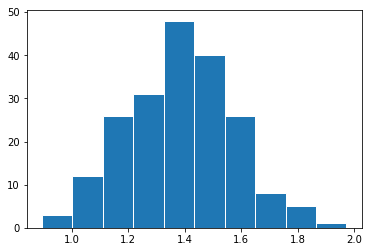

In [121]:
_ = plt.hist(param1, edgecolor='white')

Display the spread of slope estimates (actual value 2)

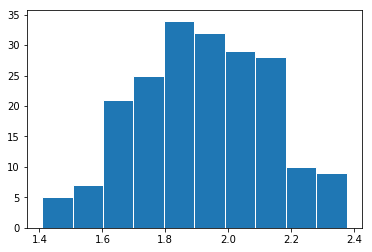

In [122]:
_ = plt.hist(param2, edgecolor='white')

Find the 95% confidence interval of the slope, based upon the repeated estimation, compared to the one-shot OLS estimate = 1.494 <-> 2.216

In [123]:
np.percentile(param2, 2.5), np.percentile(param2, 97.5)

(1.5116567769330833, 2.2939972651879335)

------
## Heavily skewed errors

We consider an exponential distribution of errors, adjusted so mean=0

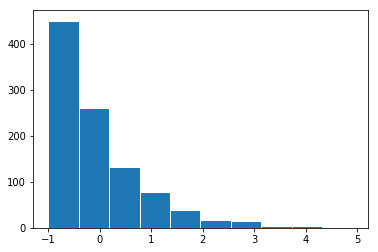

In [95]:
expn = np.random.exponential(1, 1000) - 1

_ = plt.hist(expn, edgecolor='w')

Compute the observations using this skewed error source

In [96]:
x = np.random.exponential(1, 1000)

y = 3 + 2.5 * x + x * expn

Quick plot of dataset

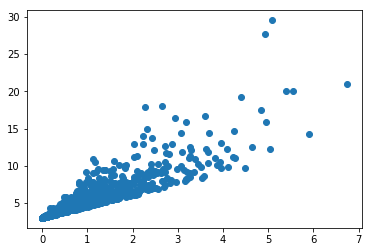

In [97]:
_ = plt.plot(x, y, 'o')

Perform OLS linear model fit

In [98]:
df_dict = {'x': x, 'y': y}
data = pd.DataFrame(df_dict)

res3 = ols('y ~ x', data=data).fit()

res3.params

Intercept    2.943530
x            2.512294
dtype: float64

Repeatedly sample original dataset with replacement, repeat OLS best fit, accumulated parameter estimate results

In [99]:
param1 = []
param2 = []

ntrials = 500
for trial in range(ntrials):
    data_sample = data.sample(frac=1, replace=True)

    res = ols('y ~ x', data=data_sample).fit()

    param1.append(res.params['Intercept'])
    param2.append(res.params['x'])
# end for

Quick plot of distribution of estimate of intercept (actual value 3

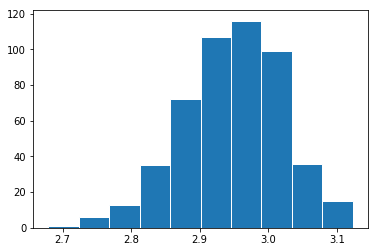

In [100]:
_ = plt.hist(param1, edgecolor='w')

Quick plot of distribution of estimate of slope (actual value 2.5

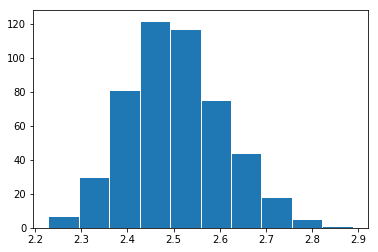

In [101]:
_ = plt.hist(param2, edgecolor='w')

In [102]:
res3.params

Intercept    2.943530
x            2.512294
dtype: float64

### Formal Visualization

We use Seaborn to prepare more detailed graphics

First the distribution of the estimate of the Intercept 

D:\Anaconda3\envs\ac5-py37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


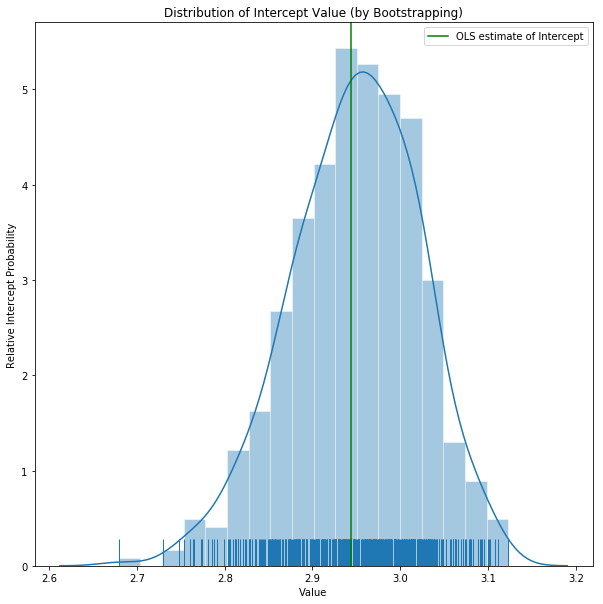

In [103]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(
    param1, rug=True, hist_kws={'edgecolor': 'w'}, ax=ax
)
ax.set_xlabel('Value')
ax.set_ylabel('Relative Intercept Probability')
ax.set_title(
    'Distribution of Intercept Value (by Bootstrapping)'
)
ax.axvline(
    res3.params['Intercept'],
    color='g',
    label='OLS estimate of Intercept',
)
ax.legend(loc='best')

And now the distribution of the estimate of the slope

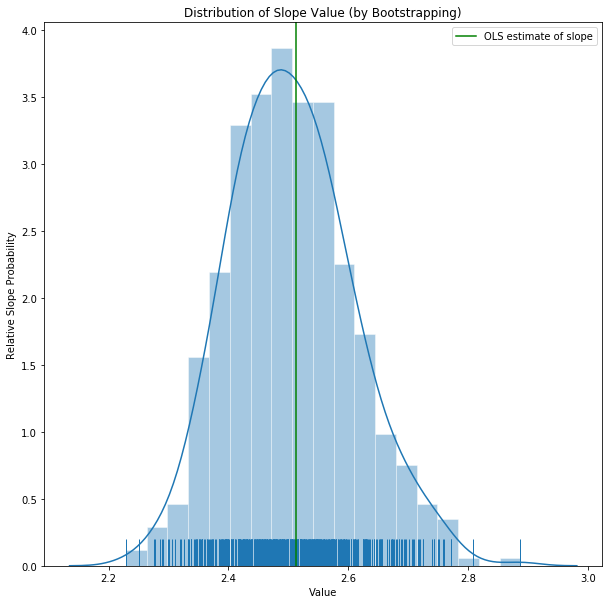

In [104]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.distplot(param2, rug=True, hist_kws={'edgecolor': 'w'})

ax.set_xlabel('Value')
ax.set_ylabel('Relative Slope Probability')
ax.set_title(
    'Distribution of Slope Value (by Bootstrapping)'
)
ax.axvline(
    res3.params['x'],
    color='g',
    label='OLS estimate of slope',
)
ax.legend(loc='best')

Finally, a quick plot of the OLS fit

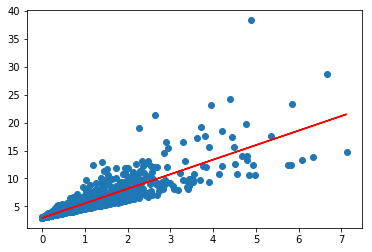

In [41]:
_ = plt.plot(x, y, 'o')
_ = plt.plot(x, res3.predict(), 'r-')

-----
## Environment

In [125]:
%watermark -h -iv
%watermark

numpy       1.15.4
seaborn     0.9.0
statsmodels 0.9.0
matplotlib  3.0.2
pandas      1.0.0
scipy       1.1.0
host name: DESKTOP-SODFUN6
2020-04-19T20:10:22+10:00

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit


In [126]:
sm.show_versions()


INSTALLED VERSIONS
------------------
Python: 3.7.1.final.0

Statsmodels

Installed: 0.9.0 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\statsmodels)

Required Dependencies

cython: 0.29.2 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\Cython)
numpy: 1.15.4 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\numpy)
scipy: 1.1.0 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\scipy)
pandas: 1.0.0 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\pandas)
    dateutil: 2.7.5 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\dateutil)
patsy: 0.5.1 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\patsy)

Optional Dependencies

matplotlib: 3.0.2 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\matplotlib)
    backend: module://ipykernel.pylab.backend_inline 
cvxopt: Not installed
joblib: 0.13.2 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\joblib)

Developer Tools

IPython: 7.2.0 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\IPython)
    jinja2: 2.10.1 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\jinja2)
sphinx: